# MDP Algorithms with OpenAI Gym

In [62]:
import numpy as np
import gym
import gym.spaces as spaces
import time

import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

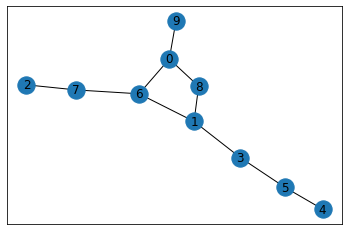

In [63]:
# Number of locations in the city
N = 10
connectivity = 2
p = 0.8

# make a random graph to represent a city network
road_network = nx.connected_watts_strogatz_graph(N, connectivity, p)
nodes = road_network.nodes

nx.draw_networkx(road_network)
plt.show()

In [64]:
class Taxi:
    """
    A taxi class to keep track of the internal state for each taxi.
    """
    def __init__(self, number, start_location):
        self._number = number
        self.available = True
        self.current_location = start_location

        self.source = []
        self.destination = []
        self.path = []
        self.path_generator = None
        self.expected_reward = 0.
        self.customer_wait_time = None
        self.current_reward = 0.

    @property
    def number(self):
        return self._number

    def hire(self, source, destination):
        if self.available == True:
            self.available = False
            self.source = source
            self.destination = destination

            self.set_path_and_reward(source, destination)
            
    def dispatch(self, destination):
        self.destination = destination
        to_destination = nx.shortest_path(road_network, self.current_location,
                                       destination)
        self.path = to_destination
        self.path_generator = (p for p in self.path)
        
        cost = len(to_destination) - 1
        self.expected_reward = -cost

            
    def set_path_and_reward(self, source, destination):
        """
        Sets a path from current location to source and then the destination.
        """
        to_customer = nx.shortest_path(road_network, self.current_location,
                                       source)
        to_destination = nx.shortest_path(road_network, source,
                                       destination)
        
        total_path = to_customer[:-1]+to_destination
        self.path = total_path
        self.path_generator = (p for p in self.path)
        
        cost_to_go_to_customer = len(to_customer) - 1
        trip_reward = 3*(len(to_destination) - 1)

        self.expected_reward += trip_reward - cost_to_go_to_customer
        self.customer_wait_time = len(to_customer) - 1


    def reset(self):
        self.available = True
        
        self.source = []
        self.destination = []
        self.path = []
        self.path_generator = None
        self.expected_reward = 0.
        self.current_reward = 0.


    def step(self):
        if self.available == True:
            try:
                self.current_location = next(self.path_generator)
                self.current_reward = -1
            except:
                self.expected_reward = 0
                self.current_reward = 0
        else:
            if (self.current_location == self.destination):
                reward = self.expected_reward
                self.reset()
                self.current_reward = reward
            else:
                self.current_location = next(self.path_generator)
    
    def __repr__(self):
        return str(self.number)

# Set taxi at location 5
taxi_test = Taxi(0, 1)

# Hire for a delivery from location
taxi_test.hire(0, 2)

print("Total path to travel", taxi_test.path)
print("Total expected reward", taxi_test.expected_reward)
print("Total customer wait time", taxi_test.customer_wait_time)

# Take a few steps
for i in range(20):
    taxi_test.step()
    print("Location: ", taxi_test.current_location, "Current reward", taxi_test.current_reward, "Expected reward", taxi_test.expected_reward)

Total path to travel [1, 8, 0, 6, 7, 2]
Total expected reward 7.0
Total customer wait time 2
Location:  1 Current reward 0.0 Expected reward 7.0
Location:  8 Current reward 0.0 Expected reward 7.0
Location:  0 Current reward 0.0 Expected reward 7.0
Location:  6 Current reward 0.0 Expected reward 7.0
Location:  7 Current reward 0.0 Expected reward 7.0
Location:  2 Current reward 0.0 Expected reward 7.0
Location:  2 Current reward 7.0 Expected reward 0.0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Current reward 0 Expected reward 0
Location:  2 Cu

In [65]:
# Set taxi at location 5
taxi_test = Taxi(0, 1)

# Hire for a delivery from location
taxi_test.dispatch(3)

print("Total path to travel", taxi_test.path)
print("Total expected reward", taxi_test.expected_reward)
print("Total customer wait time", taxi_test.customer_wait_time)

# Take a few steps
# Take a few steps
for i in range(20):
    taxi_test.step()
    print("Location: ", taxi_test.current_location, "Current reward", taxi_test.current_reward, "Expected reward", taxi_test.expected_reward)

Total path to travel [1, 3]
Total expected reward -1
Total customer wait time None
Location:  1 Current reward -1 Expected reward -1
Location:  3 Current reward -1 Expected reward -1
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
Location:  3 Current reward 0 Expected reward 0
L

In [66]:
taxi_test.expected_reward

0

In [100]:
class Environment(object):
    def __init__(self, road_network, num_taxis):
        """
        An environment to play the game
        
        Args:
            road_network (`nx.Graph`): a networkX graph representing the road network
            num_taxis (int): the number of taxi
        """
        self.road_network = road_network
        self.nodes = road_network.nodes
        self.num_nodes = len(road_network.nodes)
        
        self.num_taxis = num_taxis
        self.taxi_queue = [[] for i in range(self.num_nodes)]
        self._initialize_taxi_queue()
        
        self.queue = [[] for i in range(self.num_nodes)]
        self.generate_demand()

    def _initialize_taxi_queue(self):
        """
        Initializes a taxi queue
        """
        for i in range(self.num_taxis):
            rand_location = np.random.randint(0, self.num_nodes)
            self.taxi_queue[rand_location].append(Taxi(i, rand_location))

        
    def generate_demand(self):
        """
        Generates demands to go randomly to new locations at each point and adds to queue.

        Args:
            queue (list): a list of current demands at each location
        """
        for i, demand in enumerate(np.random.poisson(size=self.num_nodes)):
            if len(self.queue[i]) < 1:
                possible_destinations = list(self.nodes)
                possible_destinations.remove(i)
                new_destinations = np.random.choice(possible_destinations, demand)
                for d in new_destinations.ravel():
                    self.queue[i].append(d)

            
    def random_action(self):
        """
        Takes a random set of actions to assign to taxis.
        """
        actions = {}

        for node in range(self.num_nodes):
            # get one action for each available taxi in the location
            for taxi in self.taxi_queue[node]:
                if taxi.available:
                    rand_source = np.random.randint(0, self.num_nodes)
                    if (len(self.queue[rand_source]) > 1) and (np.random.random() > 0.5):
                        destination = np.random.choice(self.queue[rand_source], 1)
                        actions[taxi.number] = ("hire", rand_source, destination[0])
                    else:
                        actions[taxi.number] = ("dispatch", rand_source)
                else:
                    actions[taxi.number] = "nothing"
        return actions


    def assign(self, actions):
        """
        Assigns actions to taxis
        """
        for node, taxis in enumerate(self.taxi_queue):
            for t in taxis:
                action_to_do = actions[t._number]
                if action_to_do[0] == "hire":
                    source, destination = action_to_do[1], action_to_do[2]
                    # try to hire and remove the demand
                    if destination in self.queue[node]:
                        t.hire(source, destination)
                        self.queue[node].remove(destination)

                if action_to_do[0] == "dispatch":
                    destination = action_to_do[1]
                    # t.dispatch(destination)
                else:
                    pass
        
    def step(self, actions):
        """
        Takes a single step of the environment implementing the actions
        """
        self.assign(a)
        # Take one step for each taxi
        for taxis in self.taxi_queue:
            for t in taxis:
                t.step()

        # Assign all the actions to be performed by the taxis
        self.generate_demand()

        
    def reward(self):
        """
        
        """
        total_reward = 0
        for taxis in self.taxi_queue:
            for t in taxis:
                total_reward += t.current_reward
                
        return total_reward


    def reset(self):
        """
        Resets the environment (keeping the road network same)
        """
        self.taxi_queue = [[] for i in range(self.num_nodes)]
        self._initialize_taxi_queue()
        
        self.queue = [[] for i in range(self.num_nodes)]
        self.generate_demand()

In [101]:
taxienv = Environment(road_network, 10)
taxienv.queue

[[1, 1], [9, 5], [3], [5], [7], [9], [0], [6, 4, 6, 9], [], [3, 1]]

In [102]:
taxienv.taxi_queue

[[], [], [], [0], [3, 5], [7, 9], [6], [1, 4], [2, 8], []]

In [103]:
for i in range(3):
    taxienv.generate_demand()
    print(taxienv.queue)
    print("\n")

[[1, 1], [9, 5], [3], [5], [7], [9], [0], [6, 4, 6, 9], [0, 4], [3, 1]]


[[1, 1], [9, 5], [3], [5], [7], [9], [0], [6, 4, 6, 9], [0, 4], [3, 1]]


[[1, 1], [9, 5], [3], [5], [7], [9], [0], [6, 4, 6, 9], [0, 4], [3, 1]]




In [104]:
taxienv.queue, taxienv.taxi_queue

([[1, 1], [9, 5], [3], [5], [7], [9], [0], [6, 4, 6, 9], [0, 4], [3, 1]],
 [[], [], [], [0], [3, 5], [7, 9], [6], [1, 4], [2, 8], []])

In [105]:
taxienv.reset()

In [109]:
rval = []

for i in range(5):
    tempr = []
    taxienv.reset()
    for i in range(100):
        # print(taxienv.queue)
        a = taxienv.random_action()
        taxienv.generate_demand()
        taxienv.step(a)

        print("Reward", taxienv.reward())
        tempr.append(taxienv.reward())
        # print(taxienv.queue)
        # print("------------------------------------------")
    rval.append(tempr)

Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 8
Reward 0
Reward 0
Reward -1
Reward 0
Reward 5
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 6
Reward 2
Reward 0
Reward 12
Reward 5
Reward 0
Reward 0
Reward 9
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 8
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0.0
Reward 0.0
Reward 0.0
Reward 0.0
Reward 6
Reward 0
Reward 0
Reward 0
Reward 0
Reward 0


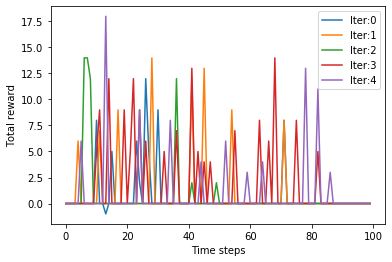

In [111]:
for i, r in enumerate(rval):
    plt.plot(r, label="Iter:{}".format(i))
plt.xlabel("Time steps")
plt.ylabel("Total reward")
plt.legend()

## 2. Setup the gym for playing with your policy

Choos an OpenAI-gym enviorment $\mathcal{E}$ and play the environment according to the given policy $\pi$.

In [25]:
def play_episodes(env, n_episodes, policy, random = False):
    """
    This fucntion plays the given number of episodes given by following a policy or sample randomly from action_space.
    
    Parameters:
        env: OpenAI-gym object
        n_episodes: number of episodes to run
        policy: Policy to follow while playing an episode
        random: Flag for taking random actions. if True no policy would be followed and action will be taken randomly
        
    Return:
        wins: Total number of wins playing n_episodes
        total_reward: Total reward of n_episodes
        avg_reward: Average reward of n_episodes
    
    """
    # intialize wins and total reward
    wins = 0
    total_reward = 0
    
    # loop over number of episodes to play
    for episode in range(n_episodes):
        
        # reset the enviorment every time when playing a new episode
        env.reset()
        
        for i in range(100):
            
            # check if the random flag is not true then follow the given policy other wise take random action
            if random:
                action = env.random_action()
            else:
                action = policy[state]

            env.step(action)
            reward = env.reward()
            
            # accumalate total reward
            total_reward += reward
            print(total_reward)
            # change the state
            
            # if game is over with positive reward then add 1.0 in wins
            if total_reward > 100:
                wins += 1
                
    # calculate average reward
    average_reward = total_reward / n_episodes
    
    return wins, total_reward, average_reward

## Let's Play Now

In [26]:
opt_Policy = [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]

In [27]:
n_episode = 10
wins, total_reward, avg_reward = play_episodes(taxienv, n_episode, opt_Policy, random = True)

-86
-172
-258
-344
-430
-516
-602
-688
-774
-860
-946
-1032
-1118
-1204
-1290
-1376
-1462
-1548
-1634
-1720
-1806
-1892
-1978
-2064
-2150
-2236
-2322
-2408
-2494
-2580
-2666
-2752
-2838
-2924
-3010
-3096
-3182
-3268
-3354
-3440
-3526
-3612
-3698
-3784
-3870
-3956
-4042
-4128
-4214
-4300
-4386
-4472
-4558
-4644
-4730
-4816
-4902
-4988
-5074
-5160
-5246
-5332
-5418
-5504
-5590
-5676
-5762
-5848
-5934
-6020
-6106
-6192
-6278
-6364
-6450
-6536
-6622
-6708
-6794
-6880
-6966
-7052
-7138
-7224
-7310
-7396
-7482
-7568
-7654
-7740
-7826
-7912
-7998
-8084
-8170
-8256
-8342
-8428
-8514
-8600
-8686
-8772
-8858
[]
-8944
-9030
-9116
-9202
-9288
-9374
-9460
-9546
-9632
-9718
-9804
-9890
-9963
-10049
-10135
-10221
-10307
-10393
-10479
-10565
-10651
-10737
-10823
-10909
-10995
-11081
-11167
-11253
-11339
-11425
-11511
-11597
-11683
-11769
-11855
-11941
-12027
-12113
-12199
-12285
-12371
-12457
-12543
-12629
-12715
-12801
-12887
-12973
-13059
-13145
-13231
-13317
-13403
-13489
-13575
-13661
-13747
-1383

In [28]:
print(wins, total_reward, avg_reward)

0 -85910.0 -8591.0
